In [21]:
from mltrace import Component, clean_db
from mltrace.client import create_labels, retract_labels

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import string
import time

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
# Params

max_num_labels = int(1e5)
step_size = 10000

In [4]:
c = Component(
        name="test-ifc-commit",
        owner="shreya",
        description="Measures commit time with varying amount of labels.",
        tags=["nyc-taxicab"],
    )

In [5]:
@c.run(input_vars={"inputs": "labels"}, output_vars=["outputs"])
def run_fake_computation_with_labels(inputs, labels):
    outputs = inputs * 2
    return outputs

In [6]:
@c.run(input_vars=["inputs"], output_vars=["outputs"])
def run_fake_computation_without_labels(inputs):
    outputs = inputs * 2
    return outputs

In [7]:
def create_label(size=10, chars=string.ascii_uppercase):
    return "".join(random.choice(chars) for _ in range(size))

In [8]:
ifc_results = {}
without_ifc_results = {}

for num_labels in range(1, max_num_labels, step_size):
    print(num_labels)
    inputs = np.random.rand(1000)
    labels = [create_label() for _ in range(num_labels)]

    # time the computation
    start_time = time.time()
    run_fake_computation_with_labels(inputs=inputs, labels=labels)
    end_time = time.time()
    clean_db()

    # Log time
    ifc_results[num_labels] = end_time - start_time

    start_time = time.time()
    run_fake_computation_without_labels(inputs=inputs)
    end_time = time.time()
    without_ifc_results[num_labels] = end_time - start_time
    clean_db()


1
propagating
propagated
propagating
propagated
10001
propagating
propagated
propagating
propagated
20001
propagating
propagated
propagating
propagated
30001
propagating
propagated
propagating
propagated
40001
propagating
propagated
propagating
propagated
50001
propagating
propagated
propagating
propagated
60001
propagating
propagated
propagating
propagated
70001
propagating
propagated
propagating
propagated
80001
propagating
propagated
propagating
propagated
90001
propagating
propagated
propagating
propagated
100001
propagating
propagated
propagating
propagated
110001
propagating
propagated
propagating
propagated
120001


KeyboardInterrupt: 

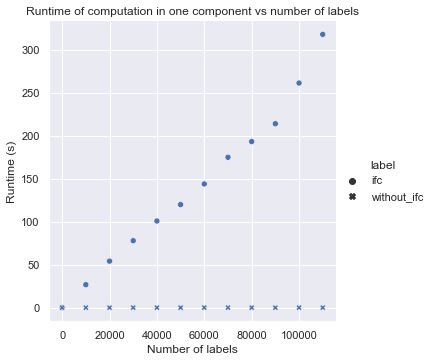

In [15]:
# Make plots

ifc_df = pd.DataFrame({"num_labels": list(ifc_results.keys()), "time": list(ifc_results.values()), "label": "ifc"})
without_ifc_df = pd.DataFrame({"num_labels": list(without_ifc_results.keys()), "time": list(without_ifc_results.values()), "label": "without_ifc"})
df = pd.concat([ifc_df, without_ifc_df])

sns.set(style="darkgrid")
sns.relplot(x="num_labels", y="time", style="label", data=df)
plt.title("Runtime of computation in one component vs number of labels")
plt.xlabel("Number of labels")
plt.ylabel("Runtime (s)")
plt.show()

## Experiments to assess how runtime changes with number of steps in the pipeline (should be linear)

In [18]:
# Vary number of steps in the pipeline

ifc_results = {}
without_ifc_results = {}
num_steps_in_pipeline = 10

for num_steps in range(1, num_steps_in_pipeline):
    print(num_steps)
    inputs = np.random.rand(1000)
    labels = [create_label() for _ in range(step_size)]

    # time the computation
    start_time = time.time()
    for _ in range(num_steps):
        inputs = run_fake_computation_with_labels(inputs=inputs, labels=labels)
    end_time = time.time()
    clean_db()

    # Log time
    ifc_results[num_steps] = end_time - start_time

    start_time = time.time()
    for _ in range(num_steps):
        inputs = run_fake_computation_without_labels(inputs=inputs)
    end_time = time.time()
    without_ifc_results[num_steps] = end_time - start_time
    clean_db()

1
propagating
propagated
propagating
propagated
2
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
3
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
4
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
5
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
6
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
propagating
propagated
7
propagating
propagat

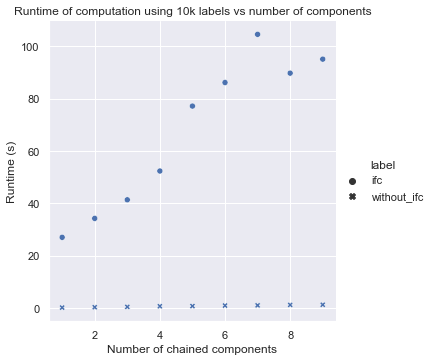

In [19]:
# Make plots

ifc_df = pd.DataFrame({"num_components": list(ifc_results.keys()), "time": list(ifc_results.values()), "label": "ifc"})
without_ifc_df = pd.DataFrame({"num_components": list(without_ifc_results.keys()), "time": list(without_ifc_results.values()), "label": "without_ifc"})
df = pd.concat([ifc_df, without_ifc_df])

sns.set(style="darkgrid")
sns.relplot(x="num_components", y="time", style="label", data=df)
plt.title("Runtime of computation using 10k labels vs number of components")
plt.xlabel("Number of chained components")
plt.ylabel("Runtime (s)")
plt.show()

## Experiments to assess how pipeline runtime varies with number of labels deleted

In [23]:
# Add 100k labels. Delete from 1 to 100k labels.

ifc_results = {}
without_ifc_results = {}
deletion_times = {}
preliminary_labels = [create_label() for _ in range(max_num_labels)]

for num_labels in range(1, max_num_labels, step_size):
    print(num_labels)
    inputs = np.random.rand(1000)
    labels = [create_label() for _ in range(step_size)]
    
    # Add labels to DB
    create_labels(preliminary_labels)

    # Delete labels from DB
    random_subset = random.sample(preliminary_labels, num_labels)
    start_time = time.time()
    retract_labels(random_subset)  
    end_time = time.time()
    deletion_times[num_labels] = end_time - start_time

    # time the computation
    start_time = time.time()
    run_fake_computation_with_labels(inputs=inputs, labels=labels)
    end_time = time.time()

    # Log time
    ifc_results[num_labels] = end_time - start_time

    start_time = time.time()
    run_fake_computation_without_labels(inputs=inputs)
    end_time = time.time()
    without_ifc_results[num_labels] = end_time - start_time
    
    # Clean DB
    clean_db()

1


TypeError: list indices must be integers or slices, not list

In [ ]:
# Make plots

ifc_df = pd.DataFrame({"num_labels": list(ifc_results.keys()), "time": list(ifc_results.values()), "label": "ifc"})
without_ifc_df = pd.DataFrame({"num_labels": list(without_ifc_results.keys()), "time": list(without_ifc_results.values()), "label": "without_ifc"})
deletion_df = pd.DataFrame({"num_labels": list(deletion_times.keys()), "time": list(deletion_times.values()), "label": "deletion"})
df = pd.concat([ifc_df, without_ifc_df, deletion_df])

sns.set(style="darkgrid")
sns.relplot(x="num_labels", y="time", style="label", data=df)
plt.title("Runtime of computation using 10k labels vs number of deleted labels")
plt.xlabel("Number of deleted labels")
plt.ylabel("Runtime (s)")
plt.show()